In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp


In [2]:
if "CI" not in os.environ:
    df = pl.read_parquet(
        "https://osf.io/gk2ty/download",
        use_pyarrow=True,
    )


In [3]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("Task").replace_strict(
            {
                "AND": False,  # 2,
                "ANDNOT": False,  # 3,
                "NAND": False,  # 1,
                "NOR": True,  # 4,
                "NOT": False,  # 1,
                "OR": False,  # 3,
                "ORNOT": False,  # 2,
                "XOR": True,  # 4,
                "EQUALS": True,  # 5,
            },
        ).alias(
            "Complex Components"
        )
    )


In [4]:
if "CI" not in os.environ:
    df = df.with_columns(
        (
            pl.col("Complex Components")
            & pl.col("has task")
        ).alias(
            "Active Complex Components"
        )
    )


In [5]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("Active Complex Components").any().over(
            ["Treatment", "Run ID", "Generation Born"],
        ).alias("Has Complex Components"),
    )


In [6]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("Active Complex Components").sum().over(
            ["Treatment", "Run ID", "Generation Born", "Site"],
        ).alias("Num Complex Components"),
    )


In [7]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("SLIP_INSERTION_BOOL_MASK").any().over(
            ["Treatment", "Run ID", "Generation Born"],
        ).alias("SLIP_INSERTION_BOOL_MASK any"),
    )


In [8]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("Is Task Coding Site").any().over(
            ["Treatment", "Run ID", "Generation Born", "Site"],
        )
        .alias("is any coding site"),
    )


In [9]:
if "CI" not in os.environ:
    df = df.with_columns(
    pl.col("Is Task Coding Site Delta").sum().over(
        ["Treatment", "Run ID", "Generation Born"],
    )
    .alias("is task coding site delta sum"),
    )


In [10]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("has task").sum().over(
            ["Treatment", "Run ID", "Generation Born", "Site"],
        )
        .alias("num tasks has"),
    )


In [11]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("is any coding site").sum().over(
            ["Treatment", "Run ID", "Generation Born", "Task",],
        ).alias("num coding sites"),
    )


In [12]:
if "CI" not in os.environ:
    dfx = df.group_by(
        ["Treatment", "Run ID", "Generation Born", "num tasks has", "num coding sites", "is task coding site delta sum", "SLIP_INSERTION_BOOL_MASK any", "Has Complex Components", "Num Complex Components"],
    ).agg(
        (
            (pl.col("delta has task") == 1).any() * 2
            + (pl.col("delta has task") == -1).any()
        ).replace_strict(
            {
                0: "No change",
                1: "Task loss",
                2: "Task gain",
                3: "Task gain and loss",
            },
        )
        .alias("task change"),
    )
    dfx.write_parquet("/tmp/robustness2.pqt")
else:
    dfx = pl.read_parquet("https://osf.io/6ysq7/download", use_pyarrow=True)


teeplots/hue=slip-insertion-bool-mask-any+kind=bar+viz=catplot+x=has-complex-components+y=is-task-coding-site-delta-sum+ext=.pdf


teeplots/hue=slip-insertion-bool-mask-any+kind=bar+viz=catplot+x=has-complex-components+y=is-task-coding-site-delta-sum+ext=.png


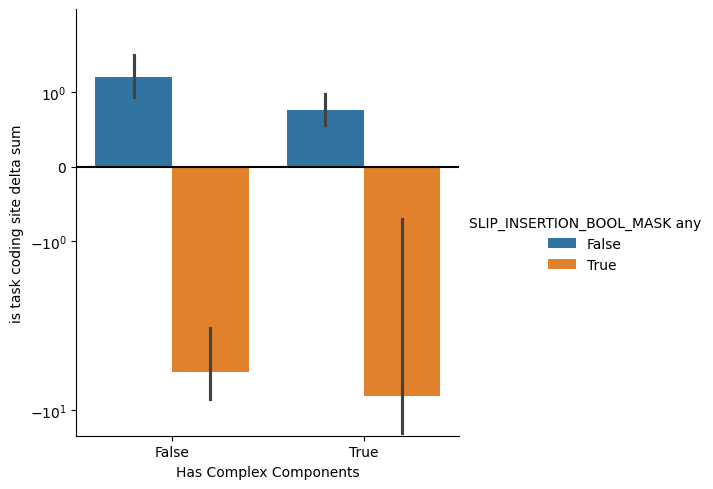

In [13]:
saveit, g = tp.tee(
    sns.catplot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    y="is task coding site delta sum",
    kind="bar",
    x="Has Complex Components",
    data=dfx.filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).to_pandas(),
    teeplot_callback=True,
)
for ax in g.axes.flat:
    ax.axhline(0, color="black")
    ax.set_yscale("symlog")

saveit()


teeplots/hue=slip-insertion-bool-mask-any+kind=strip+viz=catplot+x=has-complex-components+y=is-task-coding-site-delta-sum+ext=.pdf


teeplots/hue=slip-insertion-bool-mask-any+kind=strip+viz=catplot+x=has-complex-components+y=is-task-coding-site-delta-sum+ext=.png


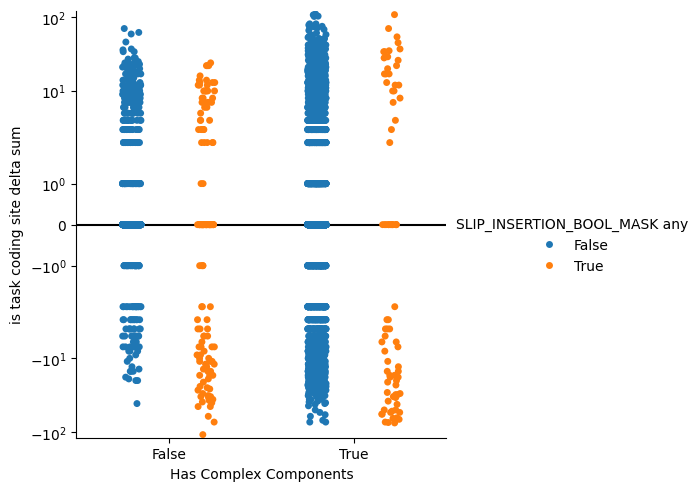

In [14]:
saveit, g = tp.tee(
    sns.catplot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    y="is task coding site delta sum",
    kind="strip",
    dodge=True,
    x="Has Complex Components",
    data=dfx.filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).to_pandas(),
    teeplot_callback=True,
)
for ax in g.axes.flat:
    ax.axhline(0, color="black")
    ax.set_yscale("symlog")

saveit()


teeplots/hue=slip-insertion-bool-mask-any+kind=hist+multiple=dodge+stat=count+viz=displot+x=has-complex-components+ext=.pdf
teeplots/hue=slip-insertion-bool-mask-any+kind=hist+multiple=dodge+stat=count+viz=displot+x=has-complex-components+ext=.png


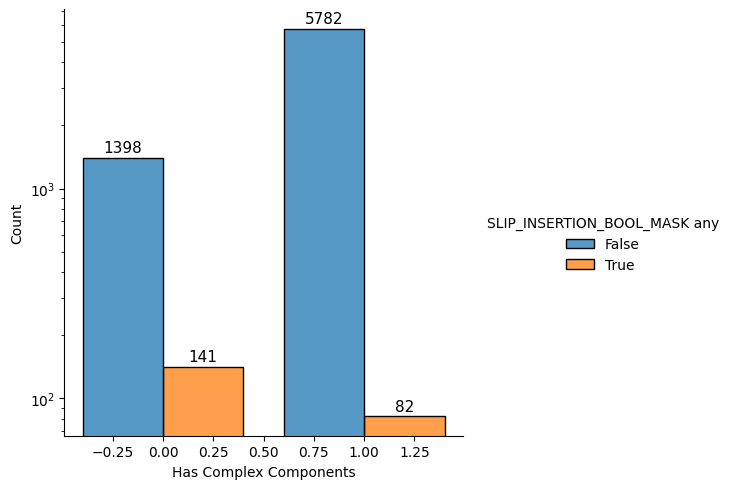

In [15]:
saveit, g = tp.tee(
    sns.displot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    kind="hist",
    x="Has Complex Components",
    data=dfx.filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).to_pandas().astype(
        {"num tasks has": "category"},
    ),
    teeplot_callback=True,
    stat="count",
    multiple="dodge",
    shrink=0.8,
    discrete=True,

)
plt.yscale('log')

# add count labels
# adapted from https://stackoverflow.com/a/55319634/17332200
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(
            text=f"{p.get_height():1.0f}",
            xy=(p.get_x() + p.get_width() / 2., p.get_height()),
            xycoords='data',
            ha='center',
            va='center',
            fontsize=11,
            color='black',
            xytext=(0,7),
            textcoords='offset points',
            clip_on=True,                   # <---  important
        )

saveit()


teeplots/hue=has-complex-components+kind=hist+multiple=dodge+stat=count+viz=displot+x=num-tasks-has+ext=.pdf
teeplots/hue=has-complex-components+kind=hist+multiple=dodge+stat=count+viz=displot+x=num-tasks-has+ext=.png


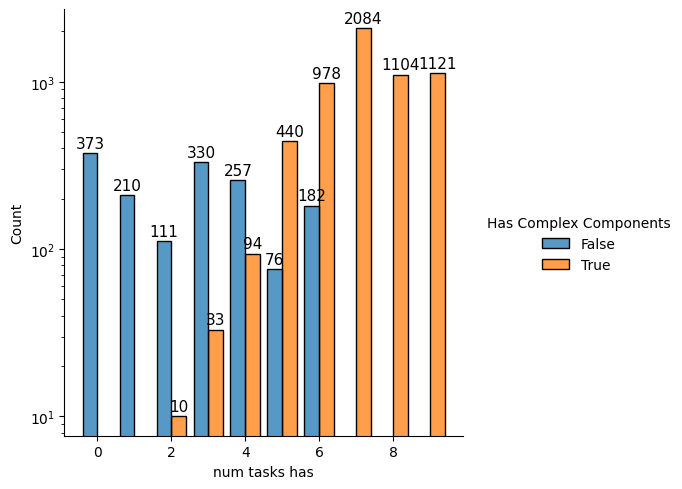

In [16]:
saveit, g = tp.tee(
    sns.displot,
    hue="Has Complex Components",
    kind="hist",
    x="num tasks has",
    data=dfx.filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).to_pandas().astype(
        {"num tasks has": "category"},
    ),
    teeplot_callback=True,
    stat="count",
    multiple="dodge",
    shrink=0.8,
    discrete=True,

)
plt.yscale('log')

# add count labels
# adapted from https://stackoverflow.com/a/55319634/17332200
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(
            text=f"{p.get_height():1.0f}",
            xy=(p.get_x() + p.get_width() / 2., p.get_height()),
            xycoords='data',
            ha='center',
            va='center',
            fontsize=11,
            color='black',
            xytext=(0,7),
            textcoords='offset points',
            clip_on=True,                   # <---  important
        )

saveit()


teeplots/hue=slip-insertion-bool-mask-any+viz=lmplot+x=num-tasks-has+y=is-task-coding-site-delta-sum+ext=.pdf
teeplots/hue=slip-insertion-bool-mask-any+viz=lmplot+x=num-tasks-has+y=is-task-coding-site-delta-sum+ext=.png


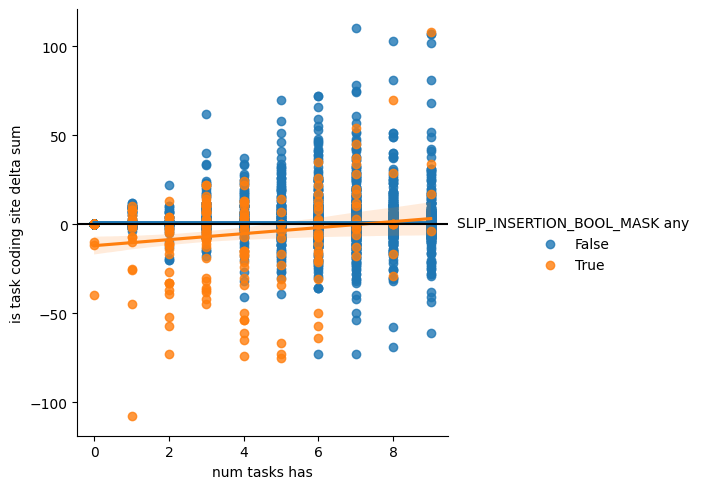

In [17]:
saveit, g = tp.tee(
    sns.lmplot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    y="is task coding site delta sum",
    x="num tasks has",
    data=dfx.filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).to_pandas(),
    teeplot_callback=True,
)
for ax in g.axes.flat:
    plt.gca().axhline(0, color="black")

saveit()


teeplots/col=has-complex-components+hue=slip-insertion-bool-mask-any+kind=bar+viz=catplot+x=num-tasks-has+y=is-task-coding-site-delta-sum+ext=.pdf


teeplots/col=has-complex-components+hue=slip-insertion-bool-mask-any+kind=bar+viz=catplot+x=num-tasks-has+y=is-task-coding-site-delta-sum+ext=.png


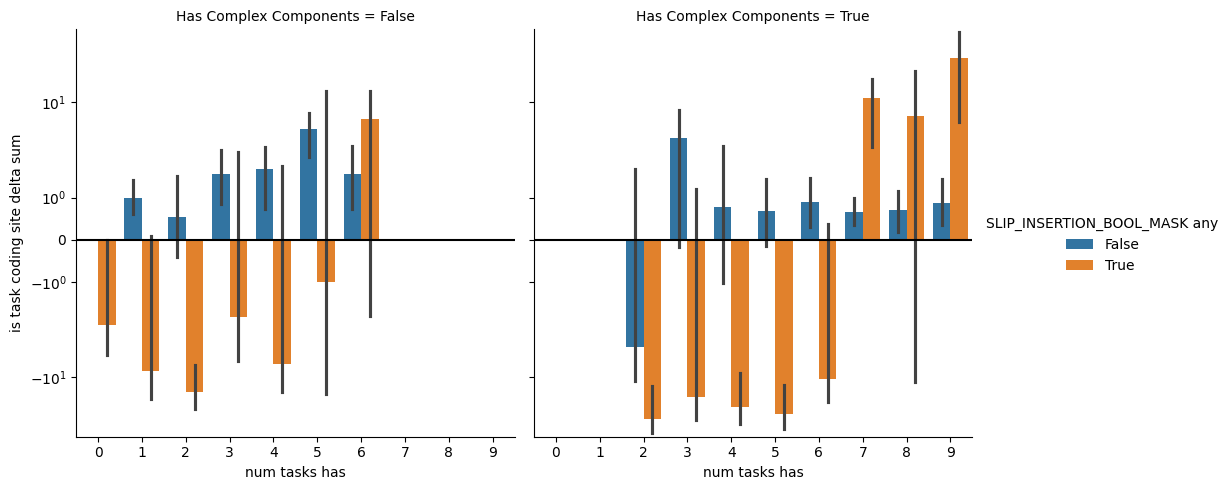

In [18]:
saveit, g = tp.tee(
    sns.catplot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    y="is task coding site delta sum",
    kind="bar",
    col="Has Complex Components",
    x="num tasks has",
    data=dfx.filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).to_pandas(),
    teeplot_callback=True,
)
for ax in g.axes.flat:
    ax.axhline(0, color="black")
    ax.set_yscale("symlog")

saveit()


teeplots/hue=slip-insertion-bool-mask-any+kind=bar+viz=catplot+x=num-complex-components+y=is-task-coding-site-delta-sum+ext=.pdf
teeplots/hue=slip-insertion-bool-mask-any+kind=bar+viz=catplot+x=num-complex-components+y=is-task-coding-site-delta-sum+ext=.png


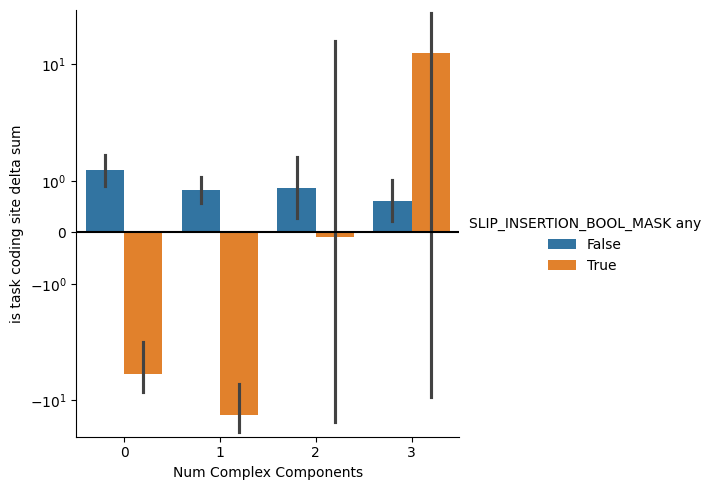

In [19]:
saveit, g = tp.tee(
    sns.catplot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    y="is task coding site delta sum",
    kind="bar",
    x="Num Complex Components",
    data=dfx.filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).to_pandas(),
    teeplot_callback=True,
)
for ax in g.axes.flat:
    ax.axhline(0, color="black")
    ax.set_yscale("symlog")

saveit()


teeplots/hue=slip-insertion-bool-mask-any+kind=strip+viz=catplot+x=num-complex-components+y=is-task-coding-site-delta-sum+ext=.pdf


teeplots/hue=slip-insertion-bool-mask-any+kind=strip+viz=catplot+x=num-complex-components+y=is-task-coding-site-delta-sum+ext=.png


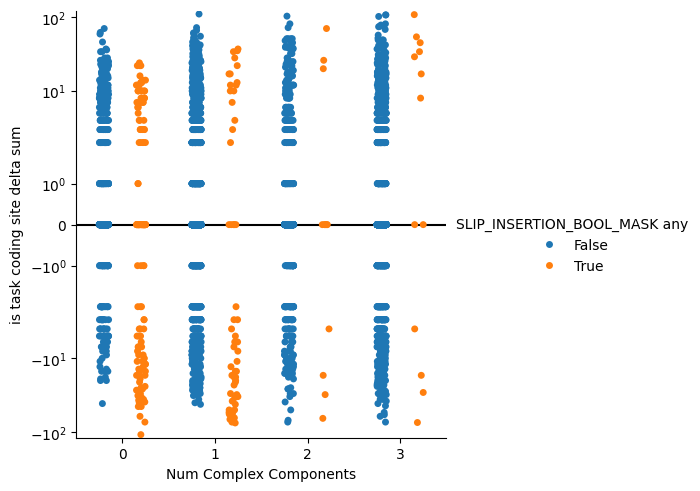

In [20]:
saveit, g = tp.tee(
    sns.catplot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    y="is task coding site delta sum",
    kind="strip",
    dodge=True,
    x="Num Complex Components",
    data=dfx.filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).to_pandas(),
    teeplot_callback=True,
)
for ax in g.axes.flat:
    ax.axhline(0, color="black")
    ax.set_yscale("symlog")

saveit()


teeplots/hue=slip-insertion-bool-mask-any+kind=hist+multiple=dodge+stat=count+viz=displot+x=num-complex-components+ext=.pdf
teeplots/hue=slip-insertion-bool-mask-any+kind=hist+multiple=dodge+stat=count+viz=displot+x=num-complex-components+ext=.png


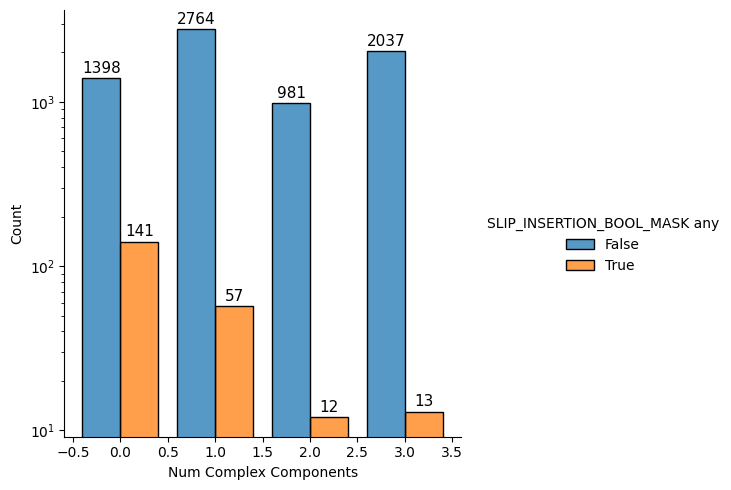

In [21]:
saveit, g = tp.tee(
    sns.displot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    kind="hist",
    x="Num Complex Components",
    data=dfx.filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).to_pandas().astype(
        {"num tasks has": "category"},
    ),
    teeplot_callback=True,
    stat="count",
    multiple="dodge",
    shrink=0.8,
    discrete=True,

)
plt.yscale('log')

# add count labels
# adapted from https://stackoverflow.com/a/55319634/17332200
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(
            text=f"{p.get_height():1.0f}",
            xy=(p.get_x() + p.get_width() / 2., p.get_height()),
            xycoords='data',
            ha='center',
            va='center',
            fontsize=11,
            color='black',
            xytext=(0,7),
            textcoords='offset points',
            clip_on=True,                   # <---  important
        )

saveit()
